In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the data
df_original = pd.read_csv("../data/sleepdata_2.csv", sep=';')

# Taking a look at the data
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Start                        921 non-null    object 
 1   End                          921 non-null    object 
 2   Sleep Quality                921 non-null    object 
 3   Regularity                   921 non-null    object 
 4   Mood                         0 non-null      float64
 5   Heart rate (bpm)             921 non-null    int64  
 6   Steps                        921 non-null    int64  
 7   Alarm mode                   921 non-null    object 
 8   Air Pressure (Pa)            492 non-null    float64
 9   City                         487 non-null    object 
 10  Movements per hour           921 non-null    float64
 11  Time in bed (seconds)        921 non-null    float64
 12  Time asleep (seconds)        921 non-null    float64
 13  Time before sleep (s

In [28]:
# DATA PREPROCESSING

# Choosing only the wanted columns
cols = [
    'Start', 'End', 'Sleep Quality', 'Regularity', 'Time in bed (seconds)',
    'Time asleep (seconds)', 'Time before sleep (seconds)', 'Movements per hour',
    'Steps', 'Air Pressure (Pa)', 'Snore time', 'Weather temperature (°C)'
]
df = df_original[cols].copy(deep=True)

# Renaming the columns
df.rename(columns={
    'Date': 'Date',
    'Weekday': 'Weekday',
    'Start': 'Start',
    'End': 'End',
    'Sleep Quality': 'SleepQuality',
    'Regularity': 'Regularity',
    'Time in bed (seconds)': 'HoursInBed',
    'Time asleep (seconds)': 'HoursAsleep',
    'Time before sleep (seconds)': 'MinutesBeforeSleep',
    'Movements per hour': 'MovementsPerHour',
    'Steps': 'Steps',
    'Air Pressure (Pa)': 'AirPressure',
    'Snore time': 'HoursSnoring',
    'Weather temperature (°C)': 'WeatherTemperature'
}, inplace=True)

# Convert start and end times to datetime objects
df[['Start', 'End']] = df[['Start', 'End']].apply(pd.to_datetime)

# Convert the values in the 'SleepQuality' and 'Regularity' column to decimal representation
df['SleepQuality'] = df['SleepQuality'].str.rstrip('%').astype('float') / 100.0
df['Regularity'] = df['Regularity'].str.rstrip('%').astype('float') / 100.0

# Convert the time values to the correct units
cols = ['HoursInBed', 'HoursAsleep', 'HoursSnoring']
df[cols] = df[cols] / 3600
df['MinutesBeforeSleep'] = df['MinutesBeforeSleep'] / 60

# For columns that are unlikely to have zero as the actual value: 
#   - Make sure that all zero values are represented as NaN
df.loc[df['Steps'] == 0, 'Steps'] = np.nan
df.loc[df['WeatherTemperature'] == 0.0, 'WeatherTemperature'] = np.nan
df.loc[df['MinutesBeforeSleep'] == 0.0, 'MinutesBeforeSleep'] = np.nan
df.loc[df['MovementsPerHour'] == 0.0, 'MovementsPerHour'] = np.nan
df.loc[df['AirPressure'] == 0.0, 'AirPressure'] = np.nan
df.loc[df['SleepQuality'] == 0.0, 'SleepQuality'] = np.nan
df.loc[df['Regularity'] == 0.0, 'Regularity'] = np.nan

# Creating 'Date' and 'Weekday' columns
df['Date'] = df['Start'].dt.date
df['Weekday'] = df['Start'].dt.day_name()

# Correct the weekday and date for the days where the subject has gone to sleep after midnight
for index, row in df.iterrows():
    # If the 'Start' and 'End' days are equal, and the hour of the 'Start' datetime object is 
    # between 00:00 and 12:00, the subject has gone to sleep after midnight.
    #  In these cases, reduce the values of the 'Weekday' column and the 'Date' column by one day.
    if (row['Start'].date() == row['End'].date()) and (row['Start'].hour >= 0 and row['Start'].hour < 12):
        df.at[index, 'Weekday'] = (row['Start'] - pd.Timedelta(days=1)).day_name()
        df.at[index, 'Date'] = (row['Start'] - pd.Timedelta(days=1)).date()

# For the days that have multiple entries: choose the entry with the largest
# 'HoursInBed' value and drop the others.
max_hours_in_bed_per_day = df.groupby('Date')['HoursInBed'].idxmax()
df = df.loc[max_hours_in_bed_per_day].reset_index(drop=True)

# Drop the rows that have NaN values, excluding NaN rows in 'AirPressure' and 'WeatherTemperature'
# (i.e after the operation those should be the only columns with missing data)
exclude = ['AirPressure', 'WeatherTemperature']
df.dropna(subset=df.columns.difference(exclude), inplace=True)

# Reordering the columns
order = ['Date', 'Weekday', 'Start', 'End', 'HoursInBed', 'HoursAsleep', 'MinutesBeforeSleep', 
         'MovementsPerHour', 'SleepQuality', 'Regularity', 'Steps', 'HoursSnoring', 
         'AirPressure', 'WeatherTemperature']
df = df[order]

# Taking a look at the preprocessed data

# Print the amount of NaN values and zero values per column
print("\nNaN values per column:")
print(df.isna().sum())
print("\nZero values per (numeric) column:")
numeric_columns = df.select_dtypes(include=['float64', 'int64', 'datetime64'])
print(((numeric_columns == 0) | (numeric_columns == 0.0)).sum(), "\n")

# Then look at the dataframe
print(df.info(), "\n")
print(df.head())


NaN values per column:
Date                    0
Weekday                 0
Start                   0
End                     0
HoursInBed              0
HoursAsleep             0
MinutesBeforeSleep      0
MovementsPerHour        0
SleepQuality            0
Regularity              0
Steps                   0
HoursSnoring            0
AirPressure           553
WeatherTemperature    479
dtype: int64

Zero values per (numeric) column:
Start                   0
End                     0
HoursInBed              0
HoursAsleep             0
MinutesBeforeSleep      0
MovementsPerHour        0
SleepQuality            0
Regularity              0
Steps                   0
HoursSnoring          276
AirPressure             0
WeatherTemperature      0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
Index: 897 entries, 2 to 914
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                

,Date,Weekday,Start,End,HoursInBed,HoursAsleep,MinutesBeforeSleep,MovementsPerHour,SleepQuality,Regularity,Steps,HoursSnoring,AirPressure,WeatherTemperature
2,2019-05-14,Tuesday,2019-05-14 21:43:00,2019-05-15 06:10:41,8.461528,7.897444,3.385000,60.5,0.86,0.96,4007.0,0.020556,NaN,NaN
3,2019-05-15,Wednesday,2019-05-15 23:11:51,2019-05-16 06:13:59,7.035444,6.425694,2.815000,45.2,0.77,0.92,6578.0,0.000000,NaN,NaN
4,2019-05-16,Thursday,2019-05-16 23:12:13,2019-05-17 06:20:32,7.138444,6.281833,2.855000,44.6,0.78,0.94,4913.0,0.052222,NaN,NaN
5,2019-05-18,Saturday,2019-05-19 01:25:12,2019-05-19 08:43:11,7.299500,5.766611,2.920000,58.0,0.72,0.80,4020.0,0.000000,NaN,NaN
6,2019-05-20,Monday,2019-05-20 22:41:13,2019-05-21 06:22:58,7.695889,6.823667,3.078333,64.0,0.73,0.58,5133.0,0.000000,NaN,NaN


/home/jiris/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

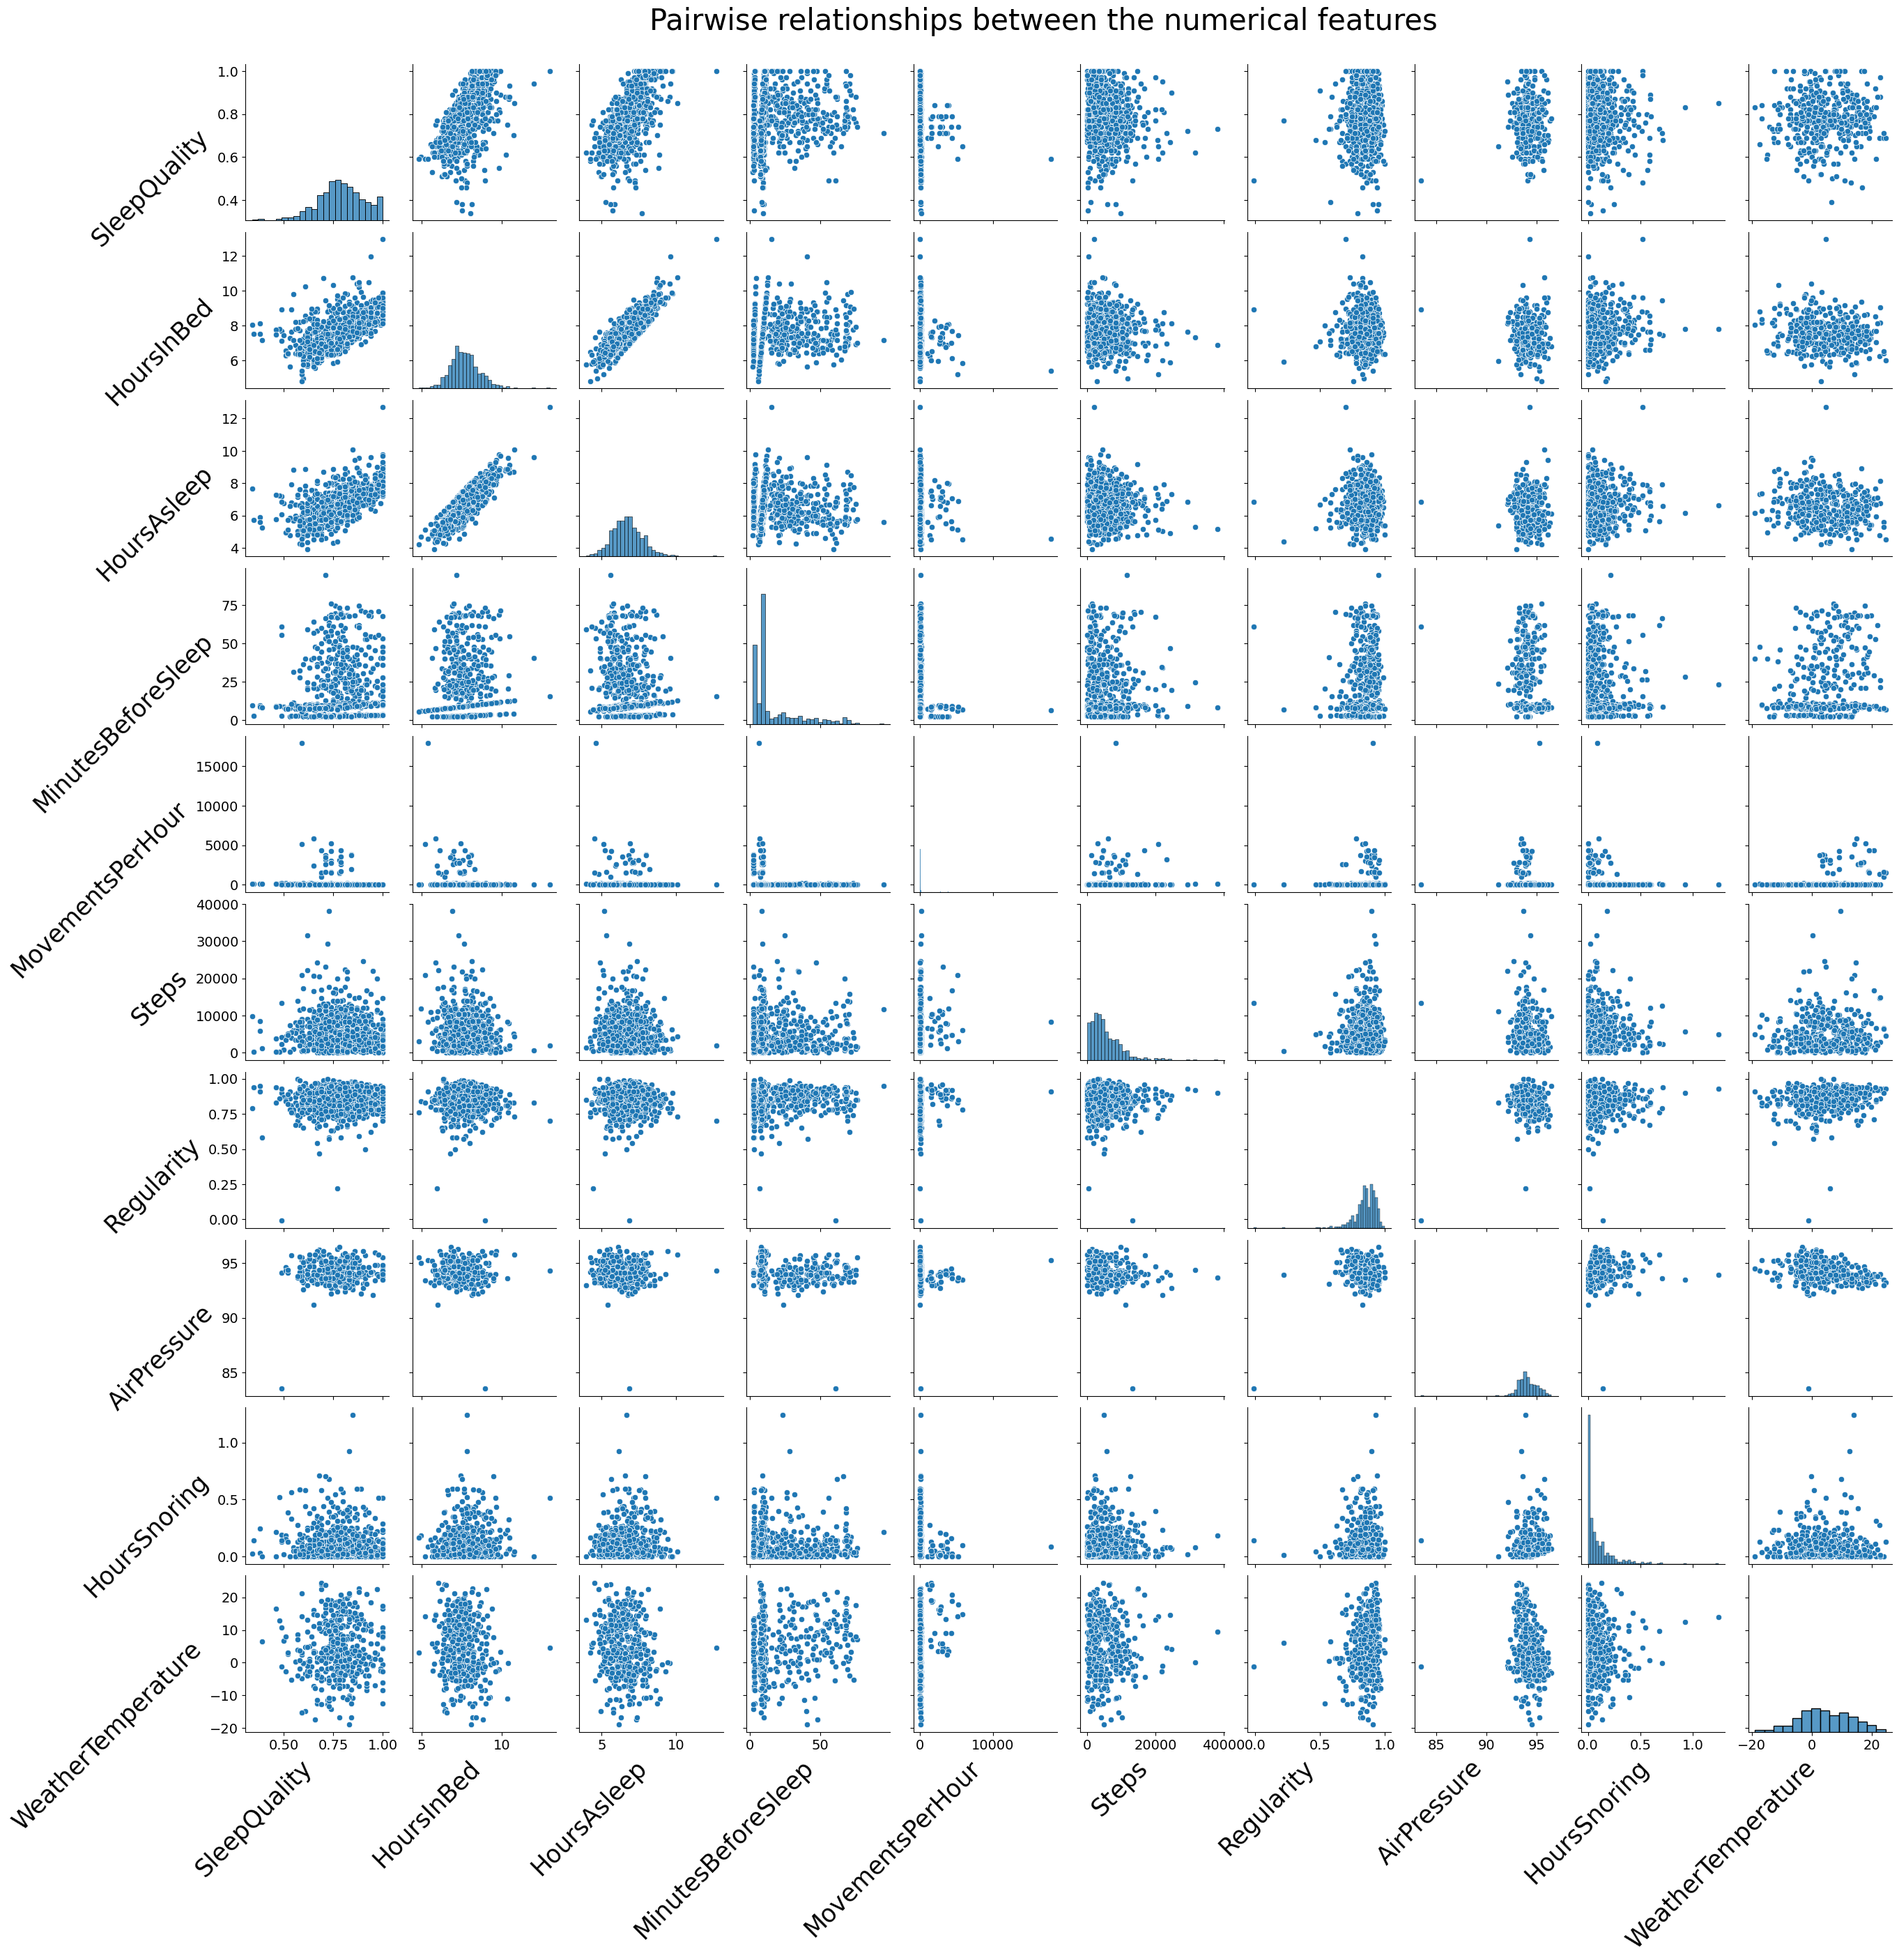

In [29]:
# CORRELATION ANALYSIS

# Let's make a correlation matrix for the columns with numerical values
df_numerical = df[['SleepQuality', 'HoursInBed', 'HoursAsleep',  'MinutesBeforeSleep', 
                   'MovementsPerHour','Steps', 'Regularity', 'AirPressure', 'HoursSnoring', 
                   'WeatherTemperature']]
plt.figure()
g = sns.pairplot(df_numerical)
# Set the title with an adjusted y position so the title is not displayed under the figure
plt.suptitle("Pairwise relationships between the numerical features", y=1.02, fontsize=30)
# Rotating labels for better readability
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), rotation=45, fontsize=25)
    ax.set_ylabel(ax.get_ylabel(), rotation=45, fontsize=25)
    ax.yaxis.get_label().set_horizontalalignment('right')
    ax.xaxis.get_label().set_horizontalalignment('right')
    ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [36]:
print(df_numerical.corr())

                    SleepQuality  \
SleepQuality            1.000000   
HoursInBed              0.551149   
HoursAsleep             0.587696   
MinutesBeforeSleep      0.086660   
MovementsPerHour       -0.110412   
Steps                  -0.071938   
Regularity              0.086574   
AirPressure             0.038477   
HoursSnoring           -0.060884   
WeatherTemperature      0.044708   

                    HoursInBed  \
SleepQuality          0.551149   
HoursInBed            1.000000   
HoursAsleep           0.868568   
MinutesBeforeSleep    0.039700   
MovementsPerHour     -0.143035   
Steps                -0.095680   
Regularity           -0.019963   
AirPressure          -0.082965   
HoursSnoring          0.088460   
WeatherTemperature   -0.120339   

                    HoursAsleep  \
SleepQuality           0.587696   
HoursInBed             0.868568   
HoursAsleep            1.000000   
MinutesBeforeSleep    -0.154946   
MovementsPerHour      -0.085515   
Steps             

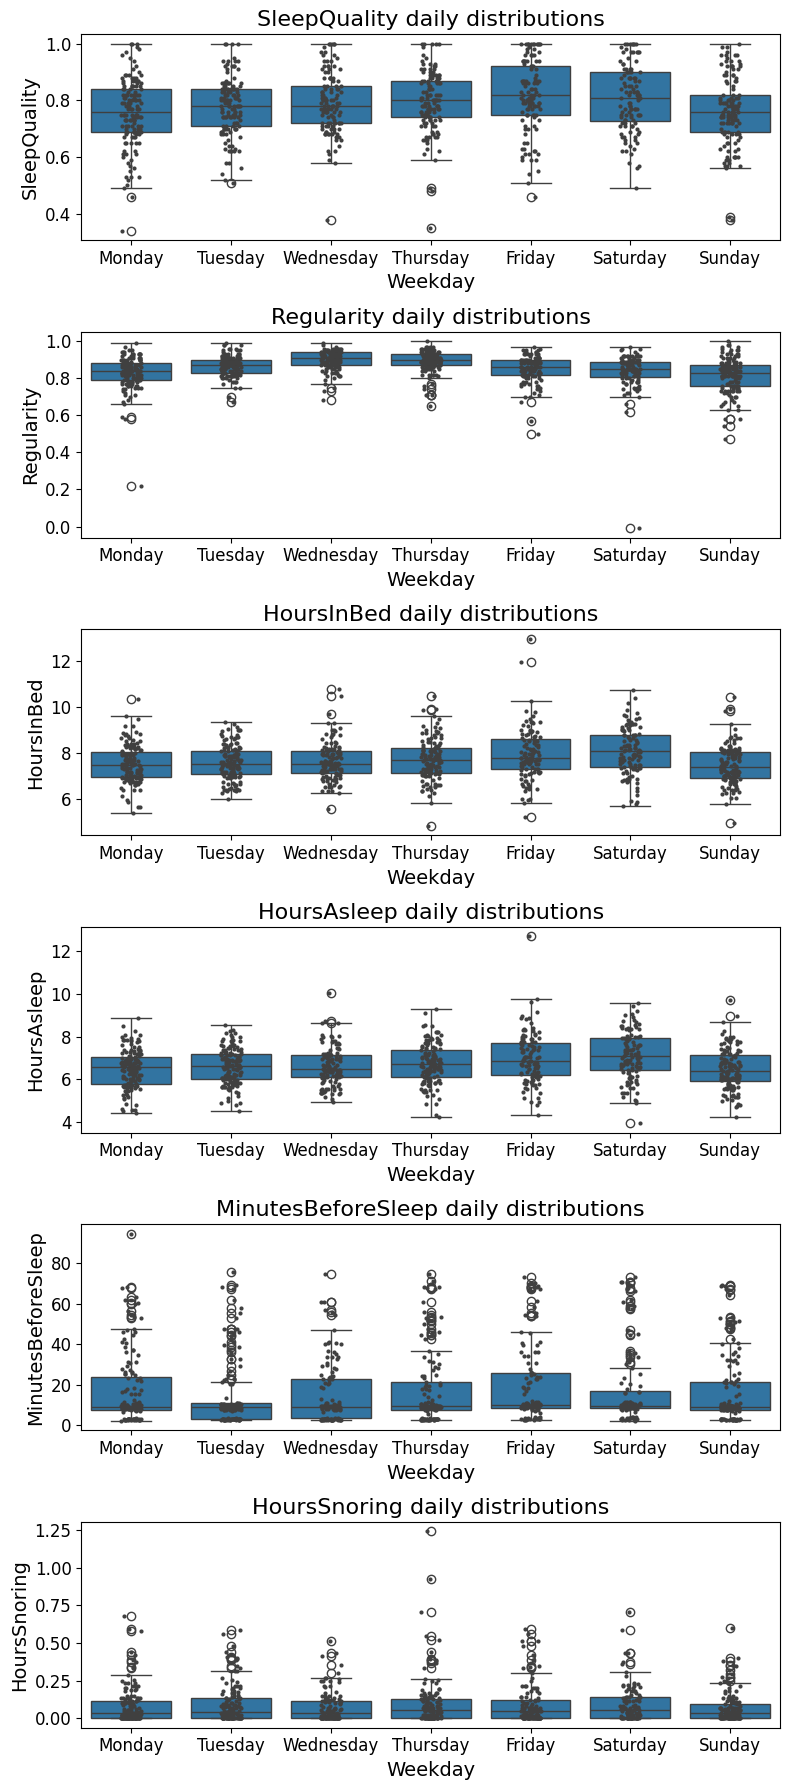

Number of datapoints per weekday: 
Weekday
Monday       144
Tuesday      136
Sunday       135
Thursday     133
Wednesday    122
Friday       115
Saturday     112
Name: count, dtype: int64


In [34]:
# TEMPORAL PATTERN ANALYSIS

order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Choose only the sleep related columns
df_subset = df[['SleepQuality', 'Regularity', 'HoursInBed', 'HoursAsleep',  
                'MinutesBeforeSleep', 'HoursSnoring']]

# Create subplots
fig, axes = plt.subplots(nrows=len(df_subset.columns), ncols=1, figsize=(8, 3*len(df_subset.columns)))

# Iterate through all the columns and create boxplots with stripplots
for i, (col, ax) in enumerate(zip(df_subset.columns, axes)):
    # Create boxplot with stripplot
    sns.boxplot(y=col, x='Weekday', order=order, data=df, ax=ax)
    sns.stripplot(y=col, x='Weekday', order=order, data=df, color=".25", size=3, ax=ax)
    
    # Set plot titles and labels
    ax.set_title(f'{col} daily distributions', fontsize=16)
    ax.set_xlabel('Weekday', fontsize=14)
    ax.set_ylabel(col, fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    
plt.tight_layout()
plt.show()

# Also print the number of datapoints per weekday
print("Number of datapoints per weekday: ")
print(df['Weekday'].value_counts())

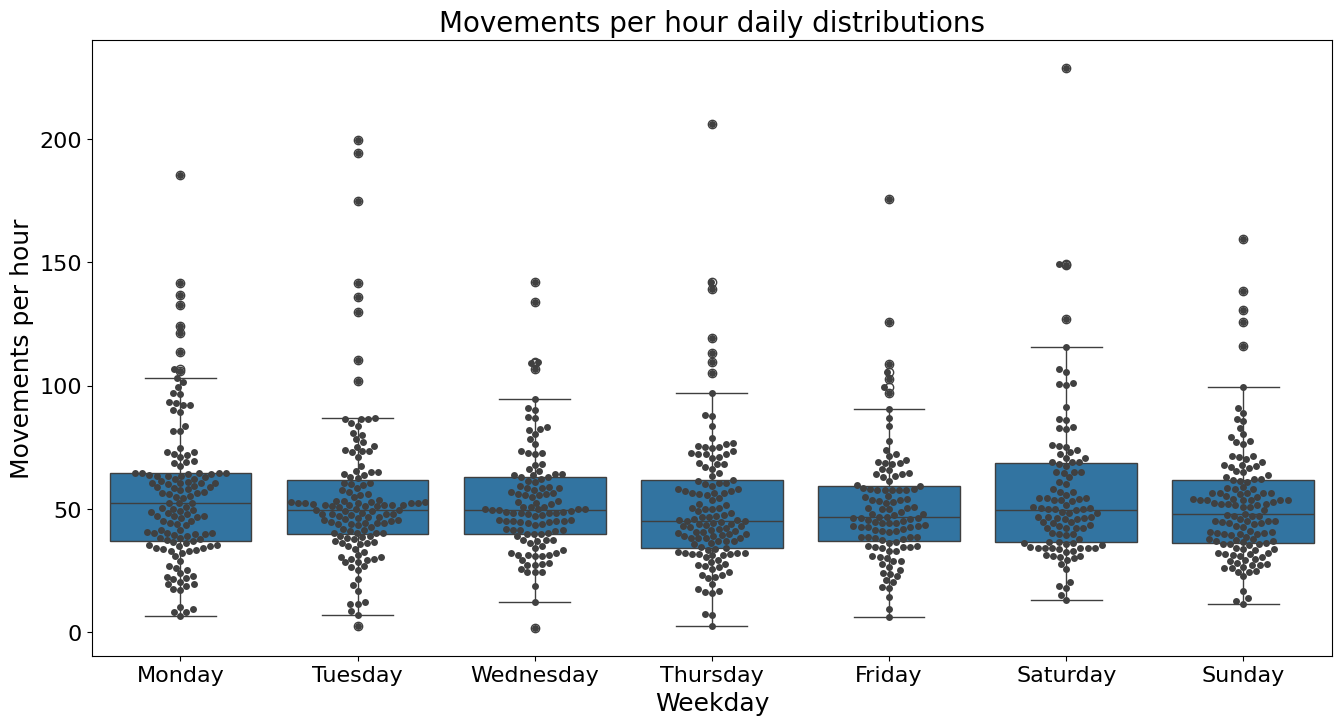

In [35]:
# Draw the movements per hour plot separately because it requires outlier removal
plt.figure(figsize=(16,8))

# Removing outliers from the boxplot plotting to get a clearer figure
filtered_df = df[(df['MovementsPerHour'] < 1000)]
ax = sns.boxplot(y="MovementsPerHour",
                 x="Weekday",
                 order=order,
                 data=filtered_df)

ax = sns.swarmplot(y="MovementsPerHour", 
                   x="Weekday",
                   order=order,
                   data=filtered_df, 
                   color=".25")

ax.set_title('Movements per hour daily distributions', fontsize=20)
ax.set_xlabel('Weekday', fontsize=18)
ax.set_ylabel('Movements per hour', fontsize=18)
ax.tick_params(axis='both', labelsize=16)